In [1]:
# Importing the libraries for reading the dataset
import pandas as pd
import os

In [2]:
# Defining the location of the dataset
FILENAME = "./loan_dataset.csv"
DATA_URL = "http://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"

In [3]:
# Downloading the dataset if it does not exist in the location
if not os.path.exists(FILENAME):

    data = (
        pd.read_excel(io=DATA_URL, header=1)
        .drop(columns=["ID"])
        .rename(
            columns={"PAY_0": "PAY_1", "default payment next month": "default"}
        )
    )
    data.to_csv(FILENAME, sep=",", encoding="utf-8", index=False)

In [4]:
# Reading the dataset and looking at the shape
dataset = pd.read_csv(FILENAME, sep=",", encoding="utf-8")
dataset.shape

(30000, 24)

In [5]:
# Priniting the metadata of the dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  30000 non-null  int64
 1   SEX        30000 non-null  int64
 2   EDUCATION  30000 non-null  int64
 3   MARRIAGE   30000 non-null  int64
 4   AGE        30000 non-null  int64
 5   PAY_1      30000 non-null  int64
 6   PAY_2      30000 non-null  int64
 7   PAY_3      30000 non-null  int64
 8   PAY_4      30000 non-null  int64
 9   PAY_5      30000 non-null  int64
 10  PAY_6      30000 non-null  int64
 11  BILL_AMT1  30000 non-null  int64
 12  BILL_AMT2  30000 non-null  int64
 13  BILL_AMT3  30000 non-null  int64
 14  BILL_AMT4  30000 non-null  int64
 15  BILL_AMT5  30000 non-null  int64
 16  BILL_AMT6  30000 non-null  int64
 17  PAY_AMT1   30000 non-null  int64
 18  PAY_AMT2   30000 non-null  int64
 19  PAY_AMT3   30000 non-null  int64
 20  PAY_AMT4   30000 non-null  int64
 21  PAY_AMT5   3

In [6]:
# List of categorical columns
cat_columns = ['EDUCATION', 'MARRIAGE']

# Converting specified columns to categorical data type
for col in cat_columns:
    dataset[col] = dataset[col].astype("category")

# Mapping values in the 'SEX' column to 1 and 0
dataset['SEX'] = dataset['SEX'].map({1: 1, 2: 0})

In [7]:
# Extracting the "default" and "SEX" columns from the dataset and assigning them to Y and A respectively
Y, A = dataset.loc[:, "default"], dataset.loc[:, "SEX"]

# Creating dummy variables for all columns except "default" and "SEX" in the dataset
X = pd.get_dummies(dataset.drop(columns=["default","SEX"]))

# Assigning the original "SEX" column values back to the X dataframe
X["SEX"] = A.copy()

# Mapping the numerical values in the "SEX" column to strings for better readability
A_str = A.map({1: "male", 0: "female"})

In [8]:
# Importing all the necessary libraries
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.ensemble import IsolationForest
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import AllKNN, InstanceHardnessThreshold, RepeatedEditedNearestNeighbours, TomekLinks, EditedNearestNeighbours
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from fairlearn.metrics import MetricFrame, equalized_odds_difference, demographic_parity_ratio
import numpy as np
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [9]:
# Splitting the data into training and testing sets for X, Y, and A_str
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(X, 
                                                                     Y,
                                                                     A_str,
                                                                     test_size=0.2,
                                                                     stratify=Y,
                                                                     random_state=42)

In [10]:
# Decision tree parameters
d_tree_params = {
    "min_samples_leaf": 10,
    "random_state": 42
}

# Creating a pipeline with a DecisionTreeClassifier estimator
estimator = Pipeline(steps=[
    ("classifier", DecisionTreeClassifier(**d_tree_params))
])

# Fitting the estimator on the training data
estimator.fit(X_train, y_train)

Pipeline(steps=[('classifier',
                 DecisionTreeClassifier(min_samples_leaf=10, random_state=42))])

Roc score is : 0.6875636482794665


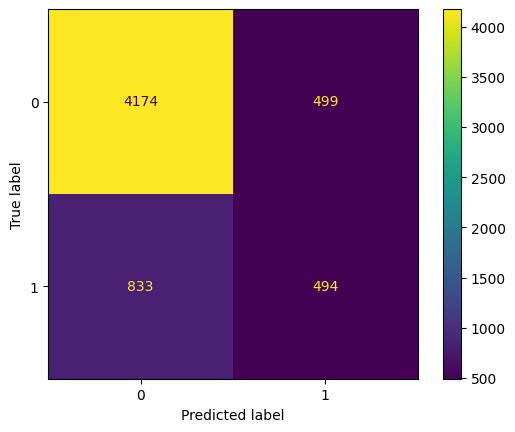

In [11]:
# Calculating the ROC and printing the Confusion Matrix
y_pred_proba = estimator.predict_proba(X_test)[:, 1]
y_pred = estimator.predict(X_test)
print(f"Roc score is : {roc_auc_score(y_test, y_pred_proba)}")

cm = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=estimator.classes_)
cm.plot()

In [12]:
# Function to compute the false positive rate
def false_positive_rate(y_true, y_pred):
    """Compute the standard error for the false positive rate estimate."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp/(fp+tn)

# Function to compute the false negative rate
def false_negative_rate(y_true, y_pred):
    """Compute the standard error for the false positive rate estimate."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn/(tp+fn)

# Dictionary of fairness metrics with corresponding functions
fairness_metrics = {
    "balanced_accuracy": balanced_accuracy_score,
    "false_positive_rate": false_positive_rate,
    "false_negative_rate": false_negative_rate,
}

# List of fairness metrics to report
metrics_to_report = list(fairness_metrics.keys())

In [13]:
# Function to calculate fairness metrics
def calculate_fairness_metrics(y_test, y_pred, A_test, metrics=fairness_metrics):
    """Function to calculate fairness metrics"""

    # Create a MetricFrame to store fairness metrics
    metricframe = MetricFrame(
        metrics=fairness_metrics,
        y_true=y_test,
        y_pred=y_pred,
        sensitive_features=A_test,
    )

    # Print fairness metrics by group
    print(metricframe.by_group[metrics_to_report])
    
    # Print differences in fairness metrics
    print("\n *diff*")
    print(metricframe.difference()[metrics_to_report])
    
    # Print overall fairness metrics
    print("\n *final_metrics*")
    print(metricframe.overall[metrics_to_report])
    
    # Calculate and print the equalized odds difference
    equalized_odds = equalized_odds_difference(
        y_test, y_pred, sensitive_features=A_test
    )
    print("\n *equalized_odds*")
    print(equalized_odds)
    
    # Calculate and print the demographic parity ratio
    dpr= demographic_parity_ratio(y_test, y_pred, sensitive_features=A_test)
    print("\n *demographic_parity_ratio*")
    print(dpr)

In [15]:
# Calling the fairness metrics function
calculate_fairness_metrics(y_test, y_pred, A_test)

        balanced_accuracy  false_positive_rate  false_negative_rate
SEX                                                                
female           0.634938             0.099576             0.630548
male             0.629122             0.117871             0.623886

 *diff*
balanced_accuracy      0.005816
false_positive_rate    0.018294
false_negative_rate    0.006662
dtype: float64

 *final_metrics*
balanced_accuracy      0.632742
false_positive_rate    0.106784
false_negative_rate    0.627732
dtype: float64

 *equalized_odds*
0.018294451247019394

 *demographic_parity_ratio*
0.8812852934911919


In [15]:
# Comparing the default rate in male and female
for val in dataset.SEX.unique():
    print(f"{('male' if val == 1 else 'female')} default rate is: ")
    print(dataset[dataset.SEX == val]['default'].mean())
    print()

female default rate is: 
0.20776280918727916

male default rate is: 
0.2416722745625841



In [16]:
# Creating the dummy variable Interest Rate
np.random.seed(42)
X.loc[:, 'Interest_rate'] = np.random.normal(loc=2*Y, scale=A.map({1:2, 0:1}))

In [17]:
# Printing some statistics
print("Maximum interest rate for men who defaulted vs women who defaulted")
print(X[(X.SEX == 1) & (Y == 1)]["Interest_rate"].max(), X[(X.SEX == 0) & (Y == 1)]["Interest_rate"].max())
print()
print("Maximum interest rate for men who did not default vs women that did not default")
print(X[(X.SEX == 1) & (Y == 0)]["Interest_rate"].max(), X[(X.SEX == 0) & (Y == 0)]["Interest_rate"].max())

Maximum interest rate for men who defaulted vs women who defaulted
9.852475412872653 6.479084251025757

Maximum interest rate for men who did not default vs women that did not default
6.857820956016427 3.852731490654721


In [18]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(X, 
                                                                     Y,
                                                                     A_str,
                                                                     test_size=0.2,
                                                                     stratify=Y,
                                                                     random_state=42)

# Parameters for the decision tree classifier
d_tree_params = {
    "min_samples_leaf": 10,
    "random_state": 42
}

# Create a pipeline with a decision tree classifier
estimator = Pipeline(steps=[
    ("classifier", DecisionTreeClassifier(**d_tree_params))
])

# Fit the estimator on the training data
estimator.fit(X_train, y_train)

Pipeline(steps=[('classifier',
                 DecisionTreeClassifier(min_samples_leaf=10, random_state=42))])

In [19]:
# Calculating the ROC
y_pred_proba = estimator.predict_proba(X_test)[:, 1]
y_pred = estimator.predict(X_test)
roc_auc_score(y_test, y_pred_proba)

0.8465698909107798

In [20]:
# Calling the fairness metrics function
calculate_fairness_metrics(y_test, y_pred, A_test)

        balanced_accuracy  false_positive_rate  false_negative_rate
SEX                                                                
female           0.813874             0.062853             0.309399
male             0.696357             0.113525             0.493761

 *diff*
balanced_accuracy      0.117517
false_positive_rate    0.050672
false_negative_rate    0.184362
dtype: float64

 *final_metrics*
balanced_accuracy      0.764922
false_positive_rate    0.082816
false_negative_rate    0.387340
dtype: float64

 *equalized_odds*
0.1843616630131758

 *demographic_parity_ratio*
0.9573799733230204


In [21]:
# Refitting the decision tree by dropping SEX variable
d_tree_params = {
    "min_samples_leaf": 10,
    "random_state": 42
}

estimator = Pipeline(steps=[
    ("classifier", DecisionTreeClassifier(**d_tree_params))
])

estimator.fit(X_train.drop(['SEX'], axis=1), y_train)

Pipeline(steps=[('classifier',
                 DecisionTreeClassifier(min_samples_leaf=10, random_state=42))])

In [22]:
# Calculating the ROC
y_pred_proba = estimator.predict_proba(X_test.drop(['SEX'], axis=1))[:, 1]
y_pred = estimator.predict(X_test.drop(['SEX'], axis=1))
roc_auc_score(y_test, y_pred_proba)

0.8392395442658211

In [23]:
# Calculating the fairness metrics
calculate_fairness_metrics_mitigated_v1 = calculate_fairness_metrics(y_test, y_pred, A_test)

        balanced_accuracy  false_positive_rate  false_negative_rate
SEX                                                                
female           0.777149             0.050141             0.395561
male             0.720184             0.121130             0.438503

 *diff*
balanced_accuracy      0.056965
false_positive_rate    0.070989
false_negative_rate    0.042941
dtype: float64

 *final_metrics*
balanced_accuracy      0.754088
false_positive_rate    0.078108
false_negative_rate    0.413715
dtype: float64

 *equalized_odds*
0.0709885778117395

 *demographic_parity_ratio*
0.75073202584666


# Undersampling methods

In [24]:
# Defining the scaler function for undersampling method AllKNN
scaler = StandardScaler()
sampler_method = AllKNN(n_jobs=-1)

In [25]:
# Creating the pipeline
sampler_pipeline = make_pipeline(
    scaler,
    sampler_method,
    estimator)

In [26]:
# Running the cross validation and scoring roc_auc and balanced_accuracy
cv_results = cross_validate(sampler_pipeline,
                            X_train.drop(['SEX'], axis=1), 
                            y_train, scoring=['roc_auc','balanced_accuracy'], 
                            return_estimator=True)

In [27]:
print(f"Validation roc auc : {cv_results['test_roc_auc'].mean():.3f} +/- {cv_results['test_roc_auc'].std():.3f}")
print(f"Validation balanced acc : {cv_results['test_balanced_accuracy'].mean():.3f} +/- {cv_results['test_balanced_accuracy'].std():.3f}")

Validation roc auc : 0.853 +/- 0.006
Validation balanced acc : 0.802 +/- 0.005


In [28]:
# Fitting the dataset and calculating roc
model = sampler_pipeline.fit( X_train.drop(['SEX'], axis=1), y_train)
y_pred_proba = model.predict_proba(X_test.drop(['SEX'],axis=1))[:, 1]
y_pred = model.predict(X_test.drop(['SEX'],axis=1))
roc_auc_score(y_test, y_pred_proba)

0.8537904984477683

In [29]:
# Printing fairness metrics
calculate_fairness_metrics_mitigated_v2 = calculate_fairness_metrics(y_test, y_pred, A_test)

        balanced_accuracy  false_positive_rate  false_negative_rate
SEX                                                                
female           0.839760             0.137712             0.182768
male             0.744553             0.254210             0.256684

 *diff*
balanced_accuracy      0.095207
false_positive_rate    0.116498
false_negative_rate    0.073917
dtype: float64

 *final_metrics*
balanced_accuracy      0.801188
false_positive_rate    0.183608
false_negative_rate    0.214017
dtype: float64

 *equalized_odds*
0.11649780425155823

 *demographic_parity_ratio*
0.7664119740094152


## Instance hardness under sampling method

In [30]:
# Parameters for the decision tree classifier
d_tree_params = {
    "min_samples_leaf": 10,
    "random_state": 42
}

# Create a decision tree classifier with the specified parameters
d_tree = DecisionTreeClassifier(**d_tree_params)

# Define a sampler method using InstanceHardnessThreshold
sampler_method = InstanceHardnessThreshold(
    estimator=d_tree,
    sampling_strategy='auto',
    random_state=42,
    n_jobs=-1,
    cv=3)

# Create a pipeline with a decision tree classifier
estimator = Pipeline(steps=[
    ("classifier", DecisionTreeClassifier(**d_tree_params))
])

# Create a pipeline with scaler, sampler, and estimator
sampler_pipeline = make_pipeline(
    scaler,
    sampler_method,
    estimator)

# Perform cross-validation with the sampler pipeline
cv_results = cross_validate(sampler_pipeline, X_train.drop(['SEX'], axis=1), y_train, scoring=['roc_auc','balanced_accuracy'], return_estimator=True)

In [31]:
print(f"Validation roc auc : {cv_results['test_roc_auc'].mean():.3f} +/- {cv_results['test_roc_auc'].std():.3f}")
print(f"Validation balanced acc : {cv_results['test_balanced_accuracy'].mean():.3f} +/- {cv_results['test_balanced_accuracy'].std():.3f}")

Validation roc auc : 0.853 +/- 0.005
Validation balanced acc : 0.807 +/- 0.007


In [32]:
# Training the model and calculating ROC on test
model = sampler_pipeline.fit( X_train.drop(['SEX'], axis=1), y_train)
y_pred_proba = model.predict_proba(X_test.drop(['SEX'],axis=1))[:, 1]
y_pred = model.predict(X_test.drop(['SEX'],axis=1))
roc_auc_score(y_test, y_pred_proba)

0.8549627959428299

In [33]:
# printing fairness metrics
calculate_fairness_metrics_mitigated_v3 = calculate_fairness_metrics(y_test, y_pred, A_test)

        balanced_accuracy  false_positive_rate  false_negative_rate
SEX                                                                
female           0.844083             0.135593             0.176240
male             0.742652             0.258012             0.256684

 *diff*
balanced_accuracy      0.101432
false_positive_rate    0.122419
false_negative_rate    0.080444
dtype: float64

 *final_metrics*
balanced_accuracy      0.802965
false_positive_rate    0.183822
false_negative_rate    0.210249
dtype: float64

 *equalized_odds*
0.1224187296881761

 *demographic_parity_ratio*
0.7596491075011778


# Oversampling methods

In [34]:
# Create a pipeline with a decision tree classifier
estimator = Pipeline(steps=[
    ("classifier", DecisionTreeClassifier(**d_tree_params))
])

# Define a SMOTE sampler method
sampler_method = SMOTE(random_state=42)

# Create a pipeline with scaler, SMOTE sampler, and the decision tree classifier
sampler_pipeline = make_pipeline(
    scaler,
    sampler_method,
    estimator)

# Perform cross-validation with the sampler pipeline
cv_results = cross_validate(sampler_pipeline, X_train.drop(['SEX'], axis=1), y_train, scoring=['roc_auc','balanced_accuracy'], return_estimator=True)

# Print the mean and standard deviation of the cross-validated roc auc and balanced accuracy
print(f"Validation roc auc : {cv_results['test_roc_auc'].mean():.3f} +/- {cv_results['test_roc_auc'].std():.3f}")
print(f"Validation balanced acc : {cv_results['test_balanced_accuracy'].mean():.3f} +/- {cv_results['test_balanced_accuracy'].std():.3f}")

# Fit the sampler pipeline on the training data and make predictions on the test data
model = sampler_pipeline.fit(X_train.drop(['SEX'], axis=1), y_train)
y_pred_proba = model.predict_proba(X_test.drop(['SEX'], axis=1))[:, 1]
y_pred = model.predict(X_test.drop(['SEX'], axis=1)

# Calculate the roc auc score for the predictions on the test data
roc_auc_score(y_test, y_pred_proba)

Validation roc auc : 0.829 +/- 0.009
Validation balanced acc : 0.758 +/- 0.012


0.8393191272926885

In [35]:
# Printing the fairness metrics
calculate_fairness_metrics_mitigated_v4 = calculate_fairness_metrics(y_test, y_pred, A_test)

        balanced_accuracy  false_positive_rate  false_negative_rate
SEX                                                                
female           0.802982             0.126412             0.267624
male             0.710597             0.208039             0.370766

 *diff*
balanced_accuracy      0.092385
false_positive_rate    0.081627
false_negative_rate    0.103142
dtype: float64

 *final_metrics*
balanced_accuracy      0.765101
false_positive_rate    0.158571
false_negative_rate    0.311228
dtype: float64

 *equalized_odds*
0.10314246752581879

 *demographic_parity_ratio*
0.833584328249994


In [36]:
# Create a pipeline with a decision tree classifier
estimator = Pipeline(steps=[
    ("classifier", DecisionTreeClassifier(**d_tree_params))
])

# Define an ADASYN sampler method
sampler_method = ADASYN(random_state=42)

# Create a pipeline with scaler, ADASYN sampler, and the decision tree classifier
sampler_pipeline = make_pipeline(
    scaler,
    sampler_method,
    estimator)

# Perform cross-validation with the sampler pipeline
cv_results = cross_validate(sampler_pipeline, X_train.drop(['SEX'], axis=1), y_train, scoring=['roc_auc','balanced_accuracy'], return_estimator=True)

# Print the mean and standard deviation of the cross-validated roc auc and balanced accuracy
print(f"Validation roc auc : {cv_results['test_roc_auc'].mean():.3f} +/- {cv_results['test_roc_auc'].std():.3f}")
print(f"Validation balanced acc : {cv_results['test_balanced_accuracy'].mean():.3f} +/- {cv_results['test_balanced_accuracy'].std():.3f}")

# Fit the sampler pipeline on the training data and make predictions on the test data
model = sampler_pipeline.fit(X_train.drop(['SEX'], axis=1), y_train)
y_pred_proba = model.predict_proba(X_test.drop(['SEX'], axis=1))[:, 1]
y_pred = model.predict(X_test.drop(['SEX'], axis=1)

# Calculate the roc auc score for the predictions on the test data
roc_auc_score(y_test, y_pred_proba)

Validation roc auc : 0.823 +/- 0.004
Validation balanced acc : 0.757 +/- 0.006


0.816654655300673

In [37]:
# Printing the fairness metrics
calculate_fairness_metrics_mitigated_v5 = calculate_fairness_metrics(y_test, y_pred, A_test)

        balanced_accuracy  false_positive_rate  false_negative_rate
SEX                                                                
female           0.790323             0.150424             0.268930
male             0.691245             0.232482             0.385027

 *diff*
balanced_accuracy      0.099078
false_positive_rate    0.082059
false_negative_rate    0.116097
dtype: float64

 *final_metrics*
balanced_accuracy      0.749619
false_positive_rate    0.182752
false_negative_rate    0.318011
dtype: float64

 *equalized_odds*
0.11609723405146533

 *demographic_parity_ratio*
0.8515482584474486


In [38]:
# Create a pipeline with a decision tree classifier
estimator = Pipeline(steps=[
    ("classifier", DecisionTreeClassifier(**d_tree_params))
])

# Define an ADASYN sampler method
sampler_method = ADASYN(random_state=42)

# Create a pipeline with scaler, ADASYN sampler, and the decision tree classifier
sampler_pipeline = make_pipeline(
    scaler,
    sampler_method,
    estimator)

# Perform cross-validation with the sampler pipeline and return the estimator
cv_results = cross_validate(sampler_pipeline, X_train.drop(['SEX'], axis=1), y_train, scoring=['roc_auc','balanced_accuracy'], return_estimator=True)

# Fit the sampler pipeline on the training data
model = sampler_pipeline.fit(X_train.drop(['SEX'], axis=1), y_train)

# Display the trained model
model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('adasyn', ADASYN(random_state=42)),
                ('pipeline',
                 Pipeline(steps=[('classifier',
                                  DecisionTreeClassifier(min_samples_leaf=10,
                                                         random_state=42))]))])

## Oversampling plus misclassified examples at random

In [39]:
# Select only the male samples from the training data
X_train_males = X_train[X_train.SEX == 1].copy()

# Make predictions for the male samples using the trained model
X_train_males["predictions"] = model.predict(X_train_males.drop(['SEX'], axis=1))

# Add true labels for the male samples
X_train_males['y_true'] = y_train.filter(X_train_males.index)

In [40]:
# Select only the male samples from train set where model made a mistake in predicting default in males
X_train_male_false_negatives = X_train_males[(X_train_males.y_true == 1) & (X_train_males.predictions == 0)]

In [41]:
# Sample a fraction (10%) of false negative male samples from the training data
X_train_sample = X_train_male_false_negatives[X_train.columns].sample(frac=0.1, replace=True, random_state=42, axis=0)

# Sample corresponding true labels for the sampled male samples
y_train_sample = X_train_male_false_negatives['y_true'].sample(frac=0.1, replace=True, random_state=42, axis=0)

In [42]:
# Combining the extracted samples with the training data
X_train_with_male_samples = pd.concat([X_train, X_train_sample], axis=0, ignore_index=True)
y_train_with_male_samples = pd.concat([y_train, y_train_sample], axis=0, ignore_index=True)

In [43]:
# Perform cross-validation using the sampler pipeline on the training data with male samples
cv_results = cross_validate(sampler_pipeline, X_train_with_male_samples.drop(['SEX'], axis=1), y_train_with_male_samples, scoring=['roc_auc','balanced_accuracy'], return_estimator=True)

# Print the mean and standard deviation of ROC AUC and balanced accuracy scores from cross-validation
print(f"Validation roc auc : {cv_results['test_roc_auc'].mean():.3f} +/- {cv_results['test_roc_auc'].std():.3f}")
print(f"Validation balanced acc : {cv_results['test_balanced_accuracy'].mean():.3f} +/- {cv_results['test_balanced_accuracy'].std():.3f}")

# Fit the sampler pipeline on the entire training data with male samples
model = sampler_pipeline.fit(X_train_with_male_samples.drop(['SEX'], axis=1), y_train_with_male_samples)

# Make predictions on the test data using the trained model
y_pred_proba = model.predict_proba(X_test.drop(['SEX'],axis=1))[:, 1]
y_pred = model.predict(X_test.drop(['SEX'],axis=1)

# Calculate the ROC AUC score on the test data
roc_auc_score(y_test, y_pred_proba)

Validation roc auc : 0.824 +/- 0.005
Validation balanced acc : 0.754 +/- 0.005


0.8201623558253082

In [44]:
# Calculating the fairness metrics
calculate_fairness_metrics_mitigated_v6 = calculate_fairness_metrics(y_test, y_pred, A_test)

        balanced_accuracy  false_positive_rate  false_negative_rate
SEX                                                                
female           0.784711             0.156427             0.274151
male             0.698027             0.231396             0.372549

 *diff*
balanced_accuracy      0.086684
false_positive_rate    0.074969
false_negative_rate    0.098398
dtype: float64

 *final_metrics*
balanced_accuracy      0.749144
false_positive_rate    0.185962
false_negative_rate    0.315750
dtype: float64

 *equalized_odds*
0.09839758357651152

 *demographic_parity_ratio*
0.8572307380135494


In [45]:
# Dictionary containing various resampling methods with their respective configurations
methods = {
    "all_knn": AllKNN(n_jobs=-1),
    "renn": RepeatedEditedNearestNeighbours(n_jobs=-1),
    "iht": InstanceHardnessThreshold(
        estimator=DecisionTreeClassifier(**d_tree_params),
        random_state=42,
        n_jobs=-1,
        cv=3),
    "tomek": TomekLinks(n_jobs=-1),
    "adasyn" : ADASYN(random_state=42),
    "smote" : SMOTE(random_state=42),
    "smoteenn": SMOTEENN(random_state=42,
                         smote=SMOTE(random_state=42),
                         enn=EditedNearestNeighbours(n_jobs=-1)
                        ),
    "smotetomek": SMOTETomek(random_state=42,
                             smote=SMOTE(random_state=42),
                             tomek=TomekLinks(n_jobs=-1)
                            )
}

In [46]:
# Function to sample false positives from the training data
def sample_false_positives(X_train, y_train, estimator, perc=0.1, subset_col="SEX", subset_col_value=1, with_replace=True):
    """Function to sample false positives"""
    
    X_train = X_train.copy()
    y_train = y_train.copy()
    X_train_subset = X_train[X_train[subset_col] == subset_col_value].copy()
    y_train_subset = y_train.filter(X_train_subset.index).copy()
    X_train_subset["predictions"] = estimator.predict(X_train_subset.drop([subset_col], axis=1))
    X_train_subset['y_true'] = y_train_subset.values
    X_train_subset_false_positives = X_train_subset[(X_train_subset.y_true == 0) & (X_train_subset.predictions == 1)]

    X_train_sample = X_train_subset_false_positives[X_train.columns].sample(frac=perc, replace=with_replace, random_state=42, axis=0)
    y_train_sample = X_train_subset_false_positives['y_true'].sample(frac=perc, replace=with_replace, random_state=42, axis=0)

    X_train_sample = pd.concat([X_train, X_train_sample], axis=0, ignore_index=True)
    y_train_sample = pd.concat([y_train, y_train_sample], axis=0, ignore_index=True)

    return X_train_sample, y_train_sample

# Function to sample false negatives from the training data
def sample_false_negatives(X_train, y_train, estimator, perc=0.1, subset_col="SEX", subset_col_value=1, with_replace=True):
    """Function to sample false positives"""
    
    X_train = X_train.copy()
    y_train = y_train.copy()
    X_train_subset = X_train[X_train[subset_col] == subset_col_value].copy()
    y_train_subset = y_train.filter(X_train_subset.index).copy()
    X_train_subset["predictions"] = estimator.predict(X_train_subset.drop([subset_col], axis=1))
    X_train_subset['y_true'] = y_train_subset.values
    X_train_subset_false_negatives = X_train_subset[(X_train_subset.y_true == 1) & (X_train_subset.predictions == 0)]

    X_train_sample = X_train_subset_false_negatives[X_train.columns].sample(frac=perc, replace=with_replace, random_state=42, axis=0)
    y_train_sample = X_train_subset_false_negatives['y_true'].sample(frac=perc, replace=with_replace, random_state=42, axis=0)

    X_train_sample = pd.concat([X_train, X_train_sample], axis=0, ignore_index=True)
    y_train_sample = pd.concat([y_train, y_train_sample], axis=0, ignore_index=True)

    return X_train_sample, y_train_sample

In [47]:
# Function to calculate metrics using the provided estimator on test data
def calculate_metrics(estimator, X_test, y_test, A_test):
    """Function to calculate metrics"""
    
    y_pred_proba = estimator.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

    equalized_odds = equalized_odds_difference(
        y_test, y_pred, sensitive_features=A_test
    )

    dpr = demographic_parity_ratio(y_test, y_pred, sensitive_features=A_test)

    return roc_auc, balanced_accuracy, equalized_odds, dpr

In [48]:
# Dictionary containing decision tree parameters
d_tree_params = {
    "min_samples_leaf": 10,
    "random_state": 42
}

# Creating a pipeline with a Decision Tree Classifier estimator
estimator = Pipeline(steps=[
    ("classifier", DecisionTreeClassifier(**d_tree_params))
])

# Iterating over sampling methods
results = []
for name, method in methods.items():

    print(f"Pipeline started for step {name}")
    
    # Creating a pipeline with a scaler, given method, and the Decision Tree Classifier estimator
    sampler_pipeline = make_pipeline(
        scaler,
        method,
        estimator)
    
    # Cross-validating the sampler pipeline on the training data
    cv_results = cross_validate(sampler_pipeline,
                                X_train.drop(['SEX'], axis=1), 
                                y_train,
                                scoring=['roc_auc','balanced_accuracy'],
                                return_estimator=True)

    # Fitting the model to the training data
    model = sampler_pipeline.fit(X_train.drop(['SEX'], axis=1), y_train)
    
    # Sampling false positives and updating the training data
    X_train_fp_updated, y_train_fp_updated = sample_false_positives(X_train=X_train,
                                                                    y_train=y_train,
                                                                    estimator=model
                                                                   )

    # Sampling false negatives and updating the training data
    X_train_fn_updated, y_train_fn_updated = sample_false_negatives(X_train=X_train,
                                                                    y_train=y_train,
                                                                    estimator=model
                                                                   )

    # Cross-validating the sampler pipeline on the updated false positives data
    cv_results_fp_updated = cross_validate(sampler_pipeline,
                                           X_train_fp_updated.drop(['SEX'], axis=1), 
                                           y_train_fp_updated,
                                           scoring=['roc_auc','balanced_accuracy'],
                                           return_estimator=True)

    # Fitting the model to the updated false positives data
    model = sampler_pipeline.fit(X_train_fp_updated.drop(['SEX'], axis=1), y_train_fp_updated)
    
    # Calculating metrics on the test data using the model trained on false positives data
    roc_auc, balanced_accuracy, equalized_odds, dpr = calculate_metrics(estimator=model,
                                                         X_test=X_test.drop(['SEX'], axis=1),
                                                         y_test=y_test,
                                                         A_test=A_test
                                                        )

    # Appending results for false positives to the results list
    results.append((name,
                    "fp_samples",
                    roc_auc,
                    balanced_accuracy,
                    equalized_odds,
                    dpr,
                    cv_results_fp_updated['test_roc_auc'].mean(),
                    cv_results_fp_updated['test_balanced_accuracy'].mean())
                  )

    # Cross-validating the sampler pipeline on the updated false negatives data
    cv_results_fn_updated = cross_validate(sampler_pipeline,
                                           X_train_fn_updated.drop(['SEX'], axis=1), 
                                           y_train_fn_updated,
                                           scoring=['roc_auc','balanced_accuracy'],
                                           return_estimator=True)

    # Fitting the model to the updated false negatives data
    model = sampler_pipeline.fit(X_train_fn_updated.drop(['SEX'], axis=1), y_train_fn_updated)
    
    # Calculating metrics on the test data using the model trained on false negatives data
    roc_auc, balanced_accuracy, equalized_odds, dpr = calculate_metrics(estimator=model,
                                                         X_test=X_test.drop(['SEX'], axis=1),
                                                         y_test=y_test,
                                                         A_test=A_test
                                                        )

    # Appending results for false negatives to the results list
    results.append((name,
                    "fn_samples",
                    roc_auc,
                    balanced_accuracy,
                    equalized_odds,
                    dpr,
                    cv_results_fn_updated['test_roc_auc'].mean(),
                    cv_results_fn_updated['test_balanced_accuracy'].mean())
                  )

    print(f"Pipeline completed for step {name}")
    print()

Pipeline started for step all_knn
Pipeline completed for step all_knn

Pipeline started for step renn
Pipeline completed for step renn

Pipeline started for step iht
Pipeline completed for step iht

Pipeline started for step tomek
Pipeline completed for step tomek

Pipeline started for step adasyn
Pipeline completed for step adasyn

Pipeline started for step smote
Pipeline completed for step smote

Pipeline started for step smoteenn
Pipeline completed for step smoteenn

Pipeline started for step smotetomek
Pipeline completed for step smotetomek



In [49]:
# Creating a pandas DataFrame from the results list with specified columns
df = pd.DataFrame(data=results,
                  columns=["method", "sample", 
                           "test_roc_auc", "test_balanced_accuracy", "equalized_odds",
                           "demographic_parity_ratio", "validation_roc_auc", "validation_balanced_accuracy"]
                 )

In [50]:
# Sorting the dataframe on equalized odds
df.sort_values(by="equalized_odds")

,method,sample,test_roc_auc,test_balanced_accuracy,equalized_odds,demographic_parity_ratio,validation_roc_auc,validation_balanced_accuracy
6,tomek,fp_samples,0.840028,0.755548,0.075251,0.766202,0.837717,0.753923
7,tomek,fn_samples,0.845239,0.762665,0.085028,0.762807,0.838964,0.752152
15,smotetomek,fn_samples,0.831481,0.759142,0.088305,0.889503,0.833660,0.759392
9,adasyn,fn_samples,0.820162,0.749144,0.098398,0.857231,0.824482,0.754271
11,smote,fn_samples,0.827696,0.759188,0.099829,0.842699,0.834220,0.762578
14,smotetomek,fp_samples,0.823669,0.758490,0.107787,0.830200,0.831226,0.757442
8,adasyn,fp_samples,0.820265,0.746181,0.108264,0.900495,0.822120,0.754570
2,renn,fp_samples,0.855651,0.808500,0.108267,0.801404,0.850112,0.803545
1,all_knn,fn_samples,0.854233,0.794824,0.110385,0.773968,0.854162,0.803953
0,all_knn,fp_samples,0.853206,0.796750,0.110388,0.763074,0.848643,0.797514


## Oversampling with anomalies

In [51]:
# Retraining on SMOTETomek, since the sampler method performed best on equalized odds
# Creating an empty DataFrame to store scaled training data
X_train_scaled = pd.DataFrame()

# Initializing a StandardScaler for scaling the data
scaler = StandardScaler() 

# Initializing a SMOTETomek sampler with specified parameters
sampler = SMOTETomek(random_state=42,
                     smote=SMOTE(random_state=42),
                     tomek=TomekLinks(n_jobs=-1)
                    )

In [52]:
# Getting column names excluding 'SEX' from X_train
columns = X_train.drop(['SEX'], axis=1).columns

# Scaling the selected columns from X_train and storing in X_train_scaled
X_train_scaled[columns] = scaler.fit_transform(X_train.drop(['SEX'], axis=1))

# Resampling the scaled training data using the sampler
X_train_resample, y_train_resample = sampler.fit_resample(X_train_scaled, y_train)

# Inverse transforming the resampled data and storing in X_train_resample
X_train_resample[columns] = scaler.inverse_transform(X_train_resample)

In [53]:
# Initializing an Isolation Forest model for detecting anomalies
anomaly_model = IsolationForest(contamination=float(.1), random_state=42, n_jobs=-1)

# Fitting the Isolation Forest model on the resampled training data
anomaly_model.fit(X_train_resample)

# Predicting anomalies and adding the result to X_train_resample
X_train_resample['IF_anomaly'] = anomaly_model.predict(X_train_resample)

# Adding the target variable 'default' to X_train_resample
X_train_resample['default'] = y_train_resample

# Filtering out additional samples identified as anomalies
X_train_additional_samples = X_train_resample[X_train_resample.IF_anomaly == -1]

# Dropping the 'IF_anomaly' column from additional samples
X_train_additional_samples.drop(['IF_anomaly'], axis=1, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [54]:
# Removing anomalies
X_train_clean = X_train_resample[X_train_resample.IF_anomaly != -1]
y_train_clean = X_train_clean.default

In [55]:
# Setting parameters for the Decision Tree classifier
d_tree_params = {
    "min_samples_leaf": 10,
    "random_state": 42
}

# Creating a pipeline with Decision Tree classifier as the estimator
estimator = Pipeline(steps=[
    ("classifier", DecisionTreeClassifier(**d_tree_params))
])

# Fitting the estimator on cleaned training data excluding 'IF_anomaly' and 'default' columns
estimator.fit(X_train_clean.drop(['IF_anomaly', 'default'], axis=1), y_train_clean)

# Predicting probabilities for test data and selecting the positive class probability
y_pred_proba = estimator.predict_proba(X_test.drop(['SEX'], axis=1))[:, 1]

# Predicting labels for test data
y_pred = estimator.predict(X_test.drop(['SEX'], axis=1))

# Calculating the ROC AUC score using the predicted probabilities and true labels
roc_auc_score(y_test, y_pred_proba)

0.8248481592937735

In [56]:
# Calculating fairness metrics
calculate_fairness_metrics(y_test, y_pred, A_test)

        balanced_accuracy  false_positive_rate  false_negative_rate
SEX                                                                
female           0.794368             0.138418             0.272846
male             0.701329             0.219446             0.377897

 *diff*
balanced_accuracy      0.093039
false_positive_rate    0.081028
false_negative_rate    0.105051
dtype: float64

 *final_metrics*
balanced_accuracy      0.756201
false_positive_rate    0.170340
false_negative_rate    0.317257
dtype: float64

 *equalized_odds*
0.10505066018811993

 *demographic_parity_ratio*
0.8413623622980747


# Shaply values to detect bias, oversample and undersample data

In [57]:
# Splitting the dataset into training and testing sets for features (X), target (Y), and sensitive attribute (A_str)
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(X, 
                                                                     Y,
                                                                     A_str,
                                                                     test_size=0.2,
                                                                     stratify=Y,
                                                                     random_state=42)

In [58]:
# Training the model
model = DecisionTreeClassifier(**d_tree_params)
model.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=10, random_state=42)

In [59]:
# Creating a SHAP TreeExplainer object for the model
explainer = shap.TreeExplainer(model)

# Calculating SHAP values for the training data
shap_values = explainer.shap_values(X_train)

In [60]:
# Accessing the SHAP value for the first instance of the first feature in the dataset
shap_values[0][0]

array([ 4.14066767e-03,  1.18731631e-02, -2.23246641e-01, -2.32653795e-02,
       -1.45181517e-02, -1.20269659e-02, -2.39415661e-04,  7.42918899e-04,
        1.03808180e-03, -6.19863882e-03, -3.95906459e-04, -3.25623889e-03,
       -2.93151055e-03, -7.50661148e-03,  6.32043125e-03, -4.79048140e-03,
       -6.07285084e-03, -8.26666488e-03,  4.60309637e-02,  9.82131153e-03,
        0.00000000e+00, -2.88275339e-05, -1.84642828e-04,  8.20571840e-05,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        3.23840664e-04, -3.33549624e-04,  8.97779790e-06,  1.57991329e-01,
        2.96097068e-01])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


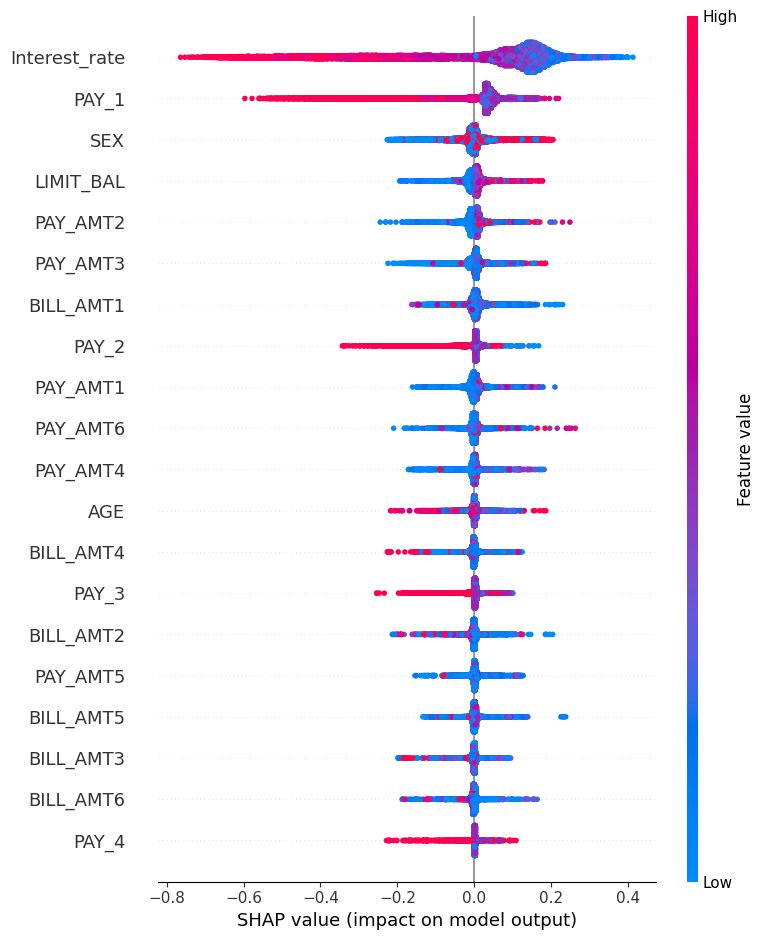

In [61]:
# Creating the summary plot for false label
shap.summary_plot(shap_values[0], X_train)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


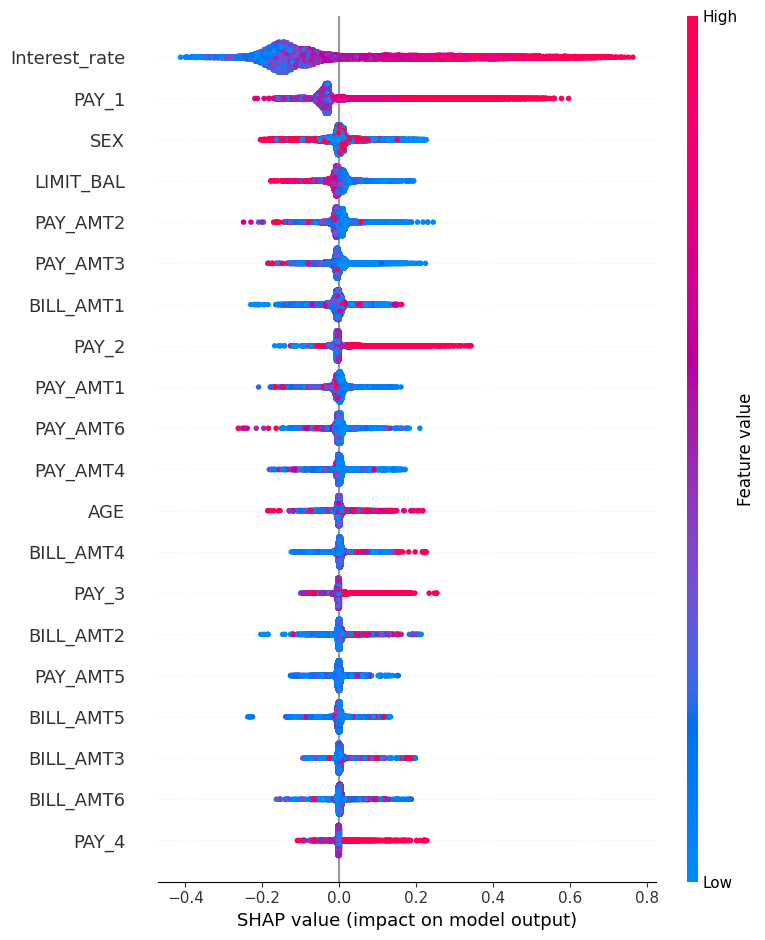

In [62]:
# Creating the summary plot for True label
shap.summary_plot(shap_values[1], X_train)

In [63]:
# Creating a Decision Tree Classifier model with specified parameters
model = DecisionTreeClassifier(**d_tree_params)

# Dropping the 'SEX' column from the training data and creating a copy
X_train_samples = X_train.drop(['SEX'], axis=1).copy()

# Creating a copy of the target variable for training
y_train_samples = y_train.copy()

# Fitting the model on the modified training data
model.fit(X_train_samples, y_train_samples)

DecisionTreeClassifier(min_samples_leaf=10, random_state=42)

In [64]:
# Creating a SHAP explainer object for the model
explainer = shap.Explainer(model)

# Calculating SHAP values for the training data using the explainer
shap_values = explainer.shap_values(X_train_samples)

In [65]:
# Calling the predict and storing in Y_pred
Y_pred = model.predict(X_train_samples)

In [66]:
print(f"Shapley value for first value in the dataset for class 0 : {sum(shap_values[0][0])}")
print(f"Shapley value for first value in the dataset for class 1 : {sum(shap_values[1][0])}")
print(f"Prediction of first value is {Y_pred[0]}")
print(f"Actual prediction is {y_train_samples[0]}")

Shapley value for first value in the dataset for class 0 : -0.07290931372549389
Shapley value for first value in the dataset for class 1 : 0.07290931372548978
Prediction of first value is 0
Actual prediction is 1


In [67]:
# Creating a list of tuples with index, predicted value, actual value, sum of SHAP values for class 0, and sum of SHAP values for class 1
data = [(index, pred, actual, sum(s0), sum(s1)) for 
        index, (pred, actual, s0, s1) in 
        enumerate(zip(Y_pred, y_train_samples, shap_values[0], shap_values[1]))
        if pred != actual]

# Creating a DataFrame from the data list with specified column names
df = pd.DataFrame(data=data, columns=["index", "predictions", "actuals", "shap_class_0", "shap_class_1"])

# Sampling 5 rows from the DataFrame with a specific random state for reproducibility
df.sample(5, random_state=42)

,index,predictions,actuals,shap_class_0,shap_class_1
422,4255,1,0,-0.478792,0.478792
1288,13255,0,1,0.087875,-0.087875
208,1972,0,1,0.110097,-0.110097
782,8169,1,0,-0.312125,0.312125
759,7915,0,1,-0.078792,0.078792


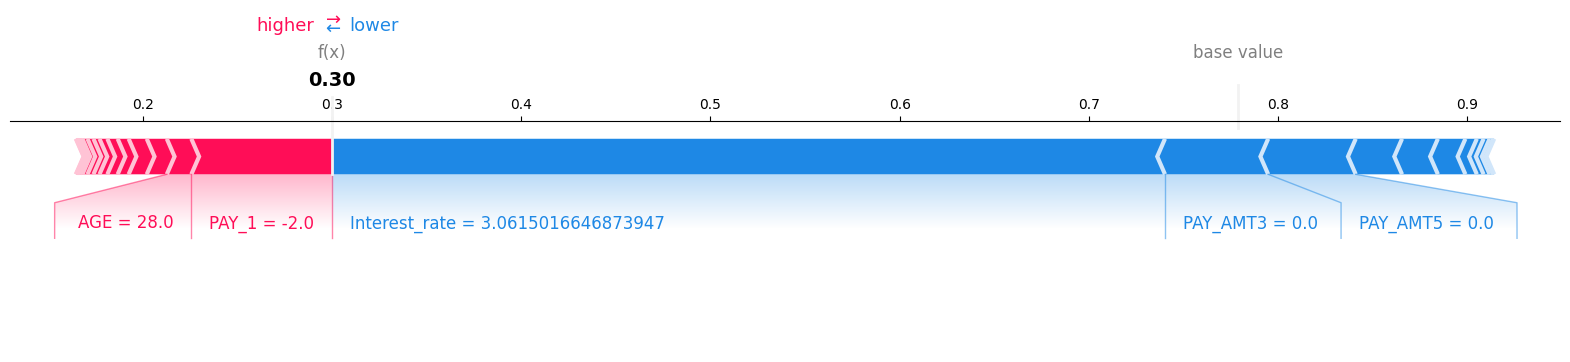

In [68]:
# Creating a force plot for class 0 to explain the prediction for a specific instance
shap.force_plot(explainer.expected_value[0], shap_values[0][4255,:], X_train_samples.iloc[4255, :], matplotlib=True)

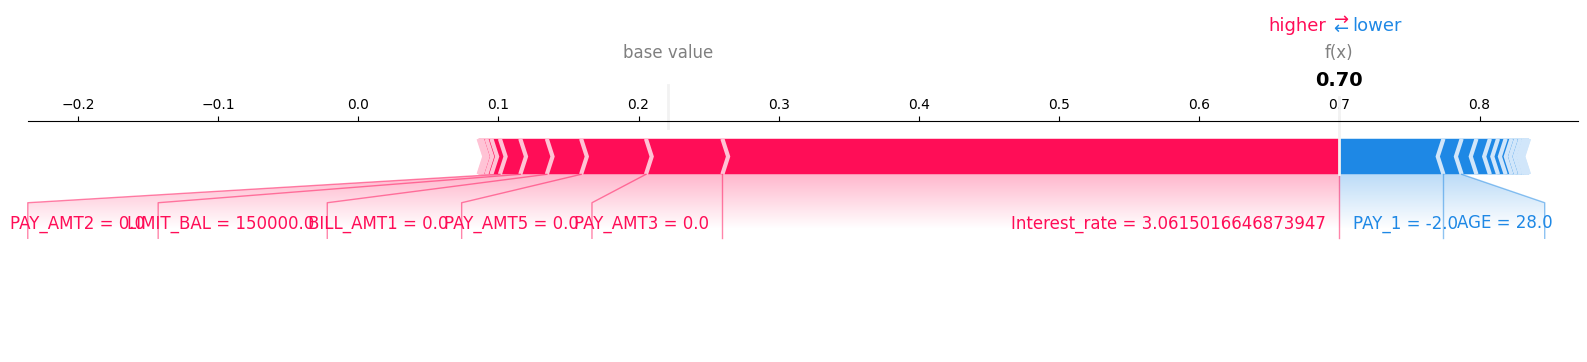

In [69]:
# Force plot for class 1 for instance 4255
shap.force_plot(explainer.expected_value[1], shap_values[1][4255,:], X_train_samples.iloc[4255, :], matplotlib=True)

In [70]:
# Calculating the absolute shap_impcat at index 422 for class 0
index = 422
shap_impact = abs(df['shap_class_0'][index])
print(shap_impact)

0.4787916666666662


In [71]:
def get_shapley_impact(shap_value, threshold=0.2):
    """Calculate Shapley impact"""
    
    # Calculating the absolute values of SHAP values
    shap_value_impacts = np.abs(shap_value)
    
    # Checking if the maximum absolute SHAP value is above the threshold
    if np.max(shap_value_impacts) >= threshold:
        # Returning the absolute sum of SHAP values if condition is met
        return np.abs(np.sum(shap_value))

In [72]:
# Splitting the training data into training and validation sets along with corresponding labels and sensitive attributes
X_train_sample, X_val, y_train_sample, y_val, A_train_sample, A_val = train_test_split(X_train, 
                                                                     y_train,
                                                                     A_train,
                                                                     test_size=0.2,
                                                                     stratify=y_train,
                                                                     random_state=42)

In [73]:
# Creating a Decision Tree Classifier model with specified parameters
model = DecisionTreeClassifier(**d_tree_params)

# Initializing a StandardScaler for feature scaling and a SMOTETomek sampler for resampling
scaler = StandardScaler()
sampler = SMOTETomek(random_state=42,
                     smote=SMOTE(random_state=42),
                     tomek=TomekLinks(n_jobs=-1)
                    )

# Storing the column names of the training sample data
columns = X_train_sample.columns

# Scaling the features of the training sample data
X_train_scaled = pd.DataFrame()
X_train_scaled[columns] = scaler.fit_transform(X_train_sample[columns])

# Resampling the scaled training data using the sampler and then inverting the scaling
X_train_resampled, y_train_resampled = sampler_method.fit_resample(X_train_scaled, y_train_sample)
X_train_resampled[columns] = scaler.inverse_transform(X_train_resampled)
A_train_resampled = X_train_resampled['SEX'].copy()

# Fitting the model on the resampled training data
model.fit(X_train_resampled.drop(['SEX'], axis=1), y_train_resampled)
Y_pred = model.predict(X_train_resampled.drop(['SEX'], axis=1))
y_val_pred = model.predict_proba(X_val.drop(['SEX'], axis=1)[:, 1]
val_roc = roc_auc_score(y_val, y_val_pred)

# Printing the ROC AUC score on the validation set
print(f"Validation roc auc : {val_roc}")

# Displaying the model
model

Validation roc auc : 0.8275769341994823


DecisionTreeClassifier(min_samples_leaf=10, random_state=42)

In [74]:
# Calculating the ROC and fairness metrics
y_pred_proba = model.predict_proba(X_test.drop(['SEX'], axis=1))[:, 1]
y_pred = model.predict(X_test.drop(['SEX'], axis=1))
print(f"Roc: {roc_auc_score(y_test, y_pred_proba)}")
calculate_fairness_metrics(y_test, y_pred, A_test)

Roc: 0.8258396009334518
        balanced_accuracy  false_positive_rate  false_negative_rate
SEX                                                                
female           0.788349             0.146540             0.276762
male             0.694428             0.224335             0.386809

 *diff*
balanced_accuracy      0.093921
false_positive_rate    0.077795
false_negative_rate    0.110047
dtype: float64

 *final_metrics*
balanced_accuracy      0.749763
false_positive_rate    0.177188
false_negative_rate    0.323286
dtype: float64

 *equalized_odds*
0.11004686707343747

 *demographic_parity_ratio*
0.8545544530463497


In [75]:
# Creating a SHAP explainer for the model
explainer = shap.Explainer(model)

# Extracting column names from the resampled training data excluding the 'SEX' column
columns = X_train_resampled.drop(['SEX'], axis=1).columns

# Calculating SHAP values for the resampled training data
shap_values = explainer.shap_values(X_train_resampled[columns])

In [76]:
# Creating a list of tuples containing SHAP impact values, index, true labels, predicted labels, Sex and additional information
shapley_impact_false_negative = [(i, get_shapley_impact(s), y, p, a) 
                                for s, i, y, p, a
                                in zip(shap_values[1], X_train_resampled.index, y_train_resampled, Y_pred, A_train_resampled)
                                 if y == 1 and p == 0 and a == 1]

In [77]:
# Creating a list of tuples containing SHAP impact values, index, true labels, predicted labels, and additional information
shapley_impact_true_negative = [(i, get_shapley_impact(s), y, p, a) 
                                for s, i, y, p, a
                                in zip(shap_values[0], X_train_resampled.index, y_train_resampled, Y_pred, A_train_resampled)
                                 if y == 0 and p == 0 and a == 1]

In [78]:
# Sorting the list of tuples based on the SHAP impact values in descending order
shapley_impact_false_negative_sorted = sorted([i for i in shapley_impact_false_negative if i[1] is not None], key=lambda x: x[1], reverse=True)

In [79]:
# Sorting the list of tuples based on the SHAP impact values in descending order
shapley_impact_true_negative_sorted = sorted([i for i in shapley_impact_true_negative if i[1] is not None], key=lambda x: x[1], reverse=True)

In [80]:
# Extracting data points to eliminate based on the top 100 false negatives' SHAP impact values
data_points_to_eliminate = [i[0] for i in shapley_impact_false_negative_sorted[0:100]]

# Extracting data points to add based on the top 100 true negatives' SHAP impact values
data_points_to_add = [i[0] for i in shapley_impact_true_negative_sorted[0:100]

# Adding data points to the training set
X_train_added = X_train_resampled[columns].iloc[data_points_to_add].sample(frac=0.5, replace=True, random_state=42, axis=0)
y_train_added = y_train_resampled.iloc[data_points_to_add].sample(frac=0.5, replace=True, random_state=42, axis=0)

# Removing data points to eliminate from the training set
X_train_reduced = X_train_resampled[columns].drop(data_points_to_eliminate)
y_train_reduced = y_train_resampled.drop(data_points_to_eliminate)

# Combining the reduced and added data points to form the final training set
X_train_final = pd.concat([X_train_reduced, X_train_added], axis=0, ignore_index=True)
y_train_final = pd.concat([y_train_reduced, y_train_added], axis=0, ignore_index=True)

In [81]:
# Creating a Decision Tree Classifier with specified parameters
estimator = DecisionTreeClassifier(**d_tree_params)
# Fitting the model on the training data
model = estimator.fit(X_train_final, y_train_final)

# Getting predicted probabilities for the positive class
y_pred_proba = model.predict_proba(X_test.drop(['SEX'], axis=1))[:, 1]
# Getting the predicted labels
y_pred = model.predict(X_test.drop(['SEX'], axis=1)

# Calculating and printing the ROC AUC score
print(f"Roc: {roc_auc_score(y_test, y_pred_proba)}")
# Calculating fairness metrics
calculate_fairness_metrics(y_test, y_pred, A_test)

Roc: 0.8262453372973797
        balanced_accuracy  false_positive_rate  false_negative_rate
SEX                                                                
female           0.785845             0.143715             0.284595
male             0.706405             0.219989             0.367201

 *diff*
balanced_accuracy      0.079440
false_positive_rate    0.076274
false_negative_rate    0.082606
dtype: float64

 *final_metrics*
balanced_accuracy      0.753359
false_positive_rate    0.173764
false_negative_rate    0.319518
dtype: float64

 *equalized_odds*
0.08260612576385884

 *demographic_parity_ratio*
0.8388834440186068


In [82]:
# Generating an array of percentages ranging from 0.05 to 0.5 with 10 equally spaced points
perc_points_to_eliminate = np.linspace(0.05, 0.5, 10)
perc_points_to_eliminate

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ])

In [83]:
# Getting the number of false negative and true negative examples
fn_examples = len(shapley_impact_false_negative)
tn_examples = len(shapley_impact_true_negative)

# Creating a Decision Tree Classifier with specified parameters
model = DecisionTreeClassifier(**d_tree_params)

data = []
# Looping over different percentages to eliminate from false negatives
for fnp in perc_points_to_eliminate:
    # Getting data points to eliminate based on Shapley impact for false negatives
    data_points_to_eliminate = [idx[0] for idx in shapley_impact_false_negative_sorted[0:(round(fn_examples*fnp))]
    
    # Looping over different percentages to eliminate from true negatives
    for tnp in perc_points_to_eliminate:
        # Getting data points to add based on Shapley impact for true negatives
        data_points_to_add = [idx[0] for idx in shapley_impact_true_negative_sorted[0:(round(tn_examples*tnp))]
        
        # Adding random samples of data from data points to add to training set
        X_train_added = X_train_resampled[columns].iloc[data_points_to_add].sample(frac=0.5, replace=True, random_state=42, axis=0)
        y_train_added = y_train_resampled.iloc[data_points_to_add].sample(frac=0.5, replace=True, random_state=42, axis=0)

        # Removing data points to eliminate from training set
        X_train_reduced = X_train_resampled[columns].drop(data_points_to_eliminate)
        y_train_reduced = y_train_resampled.drop(data_points_to_eliminate)

        # Combining reduced and added data points to create final training set
        X_train_final = pd.concat([X_train_reduced, X_train_added], axis=0, ignore_index=True)
        y_train_final = pd.concat([y_train_reduced, y_train_added], axis=0, ignore_index=True)
        
        # Fitting the model on the final training set
        model.fit(X_train_final, y_train_final)

        # Making predictions on the test set
        y_pred = model.predict(X_test.drop(['SEX'], axis=1))
        
        # Calculating false positive rate and false negative rate
        fpr = false_positive_rate(y_test, y_pred)
        fnr = false_negative_rate(y_test, y_pred)

        # Calculating Equalized Odds Difference after mitigation
        equalized_odds_mitigated = equalized_odds_difference(y_test, y_pred, sensitive_features=A_test)
        
        # Calculating Demographic Parity Ratio after mitigation
        demographic_parity_ratio_mitigated = demographic_parity_ratio(y_test, y_pred, sensitive_features=A_test)
  
        # Appending the results to the data list
        data.append((fnp, tnp, fpr, fnr, equalized_odds_mitigated, demographic_parity_ratio_mitigated))

In [84]:
# Creating a DataFrame with specified columns and data
columns = ["perc_false_negative_removed",
          "perc_true_negative_added",
          "false_positive_rate",
          "false_negative_rate",
          "equalized_odds_mitigated",
          "demographic_parity_ratio_mitigated"]

df_shapley = pd.DataFrame(data=data, columns=columns)
# Sorting the DataFrame by the 'equalized_odds_mitigated' column
df_shapley.sort_values(by="equalized_odds_mitigated")

,perc_false_negative_removed,perc_true_negative_added,false_positive_rate,false_negative_rate,equalized_odds_mitigated,demographic_parity_ratio_mitigated
45,0.25,0.30,0.165846,0.343632,0.074799,0.854371
44,0.25,0.25,0.166916,0.343632,0.077887,0.850584
34,0.20,0.25,0.165846,0.339864,0.081326,0.848495
79,0.40,0.50,0.160068,0.332329,0.082029,0.851693
25,0.15,0.30,0.170126,0.335343,0.082983,0.847364
...,...,...,...,...,...,...
15,0.10,0.30,0.164562,0.335343,0.113863,0.861112
70,0.40,0.05,0.170768,0.317257,0.114315,0.853234
61,0.35,0.10,0.167130,0.314996,0.115143,0.842758
67,0.35,0.40,0.165204,0.326300,0.120265,0.851820


In [85]:
# Sorting the DataFrame by the 'equalized_odds_mitigated' column and getting the top values
top_values = df_shapley.sort_values(by="equalized_odds_mitigated").values[0]
# Extracting the percentage of false negatives removed and true negatives added from the top values
perc_false_negative_removed = top_values[0]
perc_true_negative_added = top_values[1]

In [86]:
# Extracting column names from the resampled training data excluding the 'SEX' column
columns = X_train_resampled.drop(['SEX'], axis=1).columns
# Selecting data points to eliminate based on the percentage of false negatives removed
data_points_to_eliminate = [i[0] for i in shapley_impact_false_negative_sorted[0:(round(fn_examples*perc_false_negative_removed))]]
# Selecting data points to add based on the percentage of true negatives added
data_points_to_add = [i[0] for i in shapley_impact_true_negative_sorted[0:(round(tn_examples*perc_true_negative_added))]

# Creating a new DataFrame with added data points based on the selected indices
X_train_added = X_train_resampled[columns].iloc[data_points_to_add].sample(frac=0.5, replace=True, random_state=42, axis=0)
y_train_added = y_train_resampled.iloc[data_points_to_add].sample(frac=0.5, replace=True, random_state=42, axis=0)

# Removing data points to eliminate from the resampled training data
X_train_reduced = X_train_resampled[columns].drop(data_points_to_eliminate)
y_train_reduced = y_train_resampled.drop(data_points_to_eliminate)

# Combining reduced and added data to get the final training set
X_train_final = pd.concat([X_train_reduced, X_train_added], axis=0, ignore_index=True)
y_train_final = pd.concat([y_train_reduced, y_train_added], axis=0, ignore_index=True)

In [87]:
# Creating a Decision Tree Classifier with the specified parameters
estimator = DecisionTreeClassifier(**d_tree_params)
# Fitting the model on the final training data
model = estimator.fit(X_train_final, y_train_final)

# Predicting probabilities for the test data excluding the 'SEX' column
y_pred_proba = model.predict_proba(X_test.drop(['SEX'], axis=1))[:, 1]
# Making predictions on the test data excluding the 'SEX' column
y_pred = model.predict(X_test.drop(['SEX'], axis=1)

# Calculating and printing the ROC AUC score
print(f"Roc: {roc_auc_score(y_test, y_pred_proba)}")
# Calculating fairness metrics using the test labels, predictions, and sensitive attribute values
calculate_fairness_metrics(y_test, y_pred, A_test)

Roc: 0.820911097453972
        balanced_accuracy  false_positive_rate  false_negative_rate
SEX                                                                
female           0.773903             0.140184             0.312010
male             0.703934             0.205323             0.386809

 *diff*
balanced_accuracy      0.069969
false_positive_rate    0.065140
false_negative_rate    0.074799
dtype: float64

 *final_metrics*
balanced_accuracy      0.745261
false_positive_rate    0.165846
false_negative_rate    0.343632
dtype: float64

 *equalized_odds*
0.07479882529798065

 *demographic_parity_ratio*
0.8543712342498679
